<a href="https://colab.research.google.com/github/Saroj12Dangol/Document-Scanner/blob/2nd_defence/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing required libraries.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Conv2DTranspose,Input,Add,UpSampling2D,Dropout,concatenate
from keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
from skimage.io import imread
import plotly.express as px
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_list=os.listdir('/content/drive/MyDrive/dd')
image_list=[filename.split(".")[0]for filename in image_list]

In [ ]:
def get_segmented_img(img):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    
    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels

In [ ]:
def batch_generator(filelist,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/drive/MyDrive/dd/{fn}'+'.png', 0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
      img=np.expand_dims(img,axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/drive/MyDrive/mask (1)/{fn}'+'.png',1)
      seg=get_segmented_img(seg)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/a01-000u (2).png')
image=cv2.resize(image,(512,512),interpolation = cv2.INTER_AREA)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fig = px.imshow(image)
fig.show()
print(image.shape)

In [ ]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

#model = FCN(n_classes=2,  
            #  input_height=320, 
            #  input_width=320)
model=unet()
model.summary()

(512, 512)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Trainable params: 31,031,685
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
i = image_list
random.shuffle(i)
file_train=image_list[0:int(0.9*len(i))]
file_test=image_list[int(0.1*len(i)):]

In [ ]:
len(file_train)

97

In [ ]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('/content/drive/MyDrive/weights{epoch:08d}.h5', 
                                     save_weights_only=True, save_freq=1)
history = model.fit(batch_generator(file_train,2),
                    
                    epochs=12,steps_per_epoch=200,
                    validation_data=batch_generator(file_test,2),
                    validation_steps=400,callbacks=[mc],shuffle=1)

Epoch 1/12
200/200 [==============================] - 371s 2s/step - loss: 0.2135 - accuracy: 0.9072 - val_loss: 0.1538 - val_accuracy: 0.9329
Epoch 2/12
200/200 [==============================] - 350s 2s/step - loss: 0.1541 - accuracy: 0.9331 - val_loss: 0.1512 - val_accuracy: 0.9343
Epoch 3/12
200/200 [==============================] - 350s 2s/step - loss: 0.1441 - accuracy: 0.9368 - val_loss: 0.1488 - val_accuracy: 0.9337
Epoch 4/12
200/200 [==============================] - 356s 2s/step - loss: 0.1364 - accuracy: 0.9397 - val_loss: 0.1377 - val_accuracy: 0.9393
Epoch 5/12
200/200 [==============================] - 352s 2s/step - loss: 0.1334 - accuracy: 0.9409 - val_loss: 0.1377 - val_accuracy: 0.9412
Epoch 6/12
200/200 [==============================] - 351s 2s/step - loss: 0.1296 - accuracy: 0.9428 - val_loss: 0.1326 - val_accuracy: 0.9419
Epoch 7/12
200/200 [==============================] - 349s 2s/step - loss: 0.1304 - accuracy: 0.9418 - val_loss: 0.1365 - val_accuracy: 0.9391

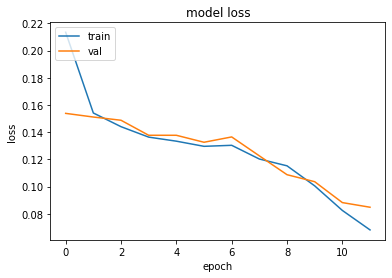

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

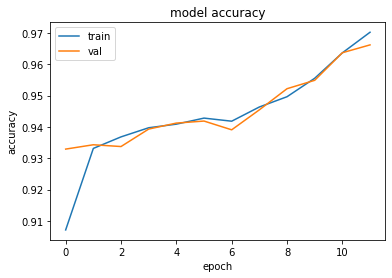

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [3]:
model.save('/content/drive/MyDrive/unet3.h5')

NameError: ignored

In [4]:
model = keras.models.load_model('/content/drive/MyDrive/unet3.h5')

In [195]:
test_img_path = '/content/drive/MyDrive/Try_image'

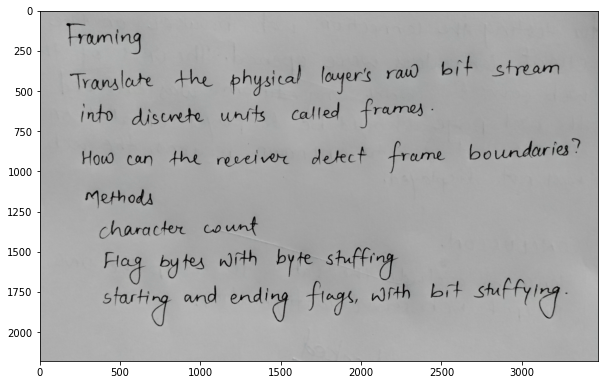

In [196]:
plt.figure(figsize=(10,9))
img = cv2.imread(test_img_path)
plt.imshow(img)

1/1 [==============================] - 10s 10s/step


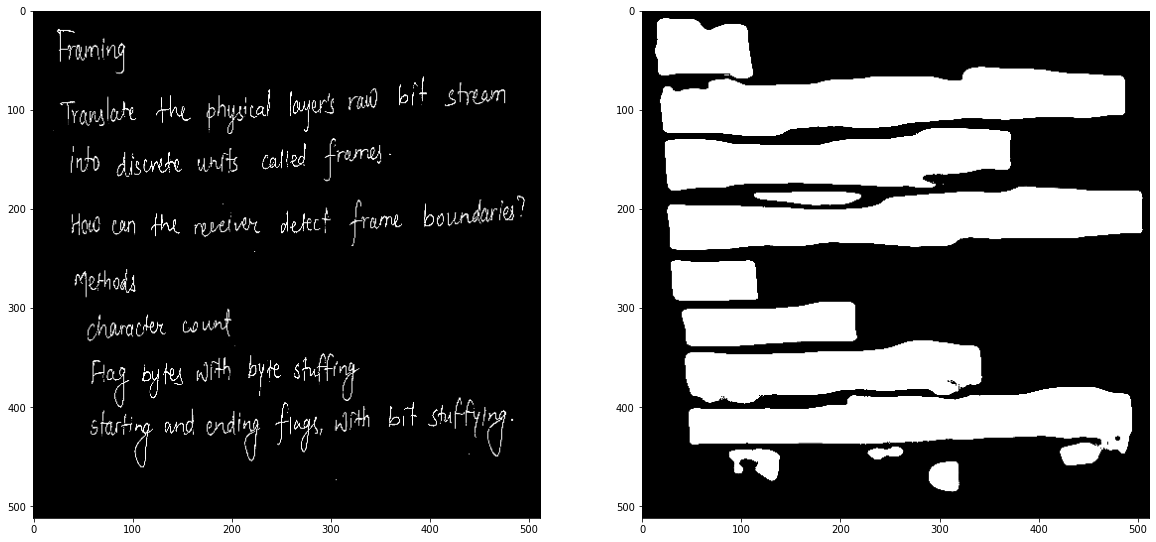

In [218]:
img=cv2.imread(test_img_path, 0)
img = cv2.GaussianBlur(img, (3,5 ), 0)


# ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
# ret,img=cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# img = cv2.erode(img, (25,25), iterations=5)

img=cv2.resize(img,(512,512))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
img= np.expand_dims(img,axis=-1)
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.subplot(122)
plt.imshow(pred,cmap='gray')
plt.imsave('test_img_mask.JPG',pred)

[[289, 455, 320, 485], [88, 442, 139, 475], [227, 440, 263, 453], [47, 380, 494, 459], [43, 333, 343, 397], [40, 294, 217, 339], [29, 252, 117, 293], [113, 183, 221, 197], [25, 178, 505, 242], [23, 119, 372, 182], [18, 57, 487, 127], [13, 8, 112, 69]]


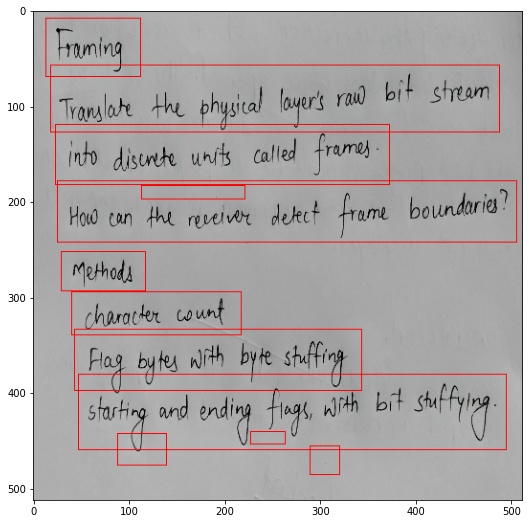

In [219]:
img = cv2.imread('/content/test_img_mask.JPG',0) 
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread(test_img_path)
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
coordinates = []
for c in contours:
    # get the bounding rect
    # print(c)
    if cv2.contourArea(c) < 100:
      continue
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
print(coordinates)
plt.figure(figsize=(10,9))
plt.imshow(ori_img)

In [199]:
len(coordinates)

11

In [200]:
cv2.imwrite('/content/drive/MyDrive/download/1.png',ori_img)

True

In [201]:
coordinates

[[289, 455, 320, 486],
 [88, 443, 138, 473],
 [224, 440, 262, 455],
 [43, 333, 494, 447],
 [40, 294, 218, 339],
 [28, 252, 117, 293],
 [113, 183, 217, 198],
 [26, 178, 504, 242],
 [23, 119, 372, 183],
 [18, 56, 487, 127],
 [13, 8, 113, 70]]

In [220]:
image = []
length_of_lines = len(coordinates)
i_cop = ori_img.copy()
for i in range(length_of_lines):
  
  cropped_image = i_cop[coordinates[i][1]:coordinates[i][3],coordinates[i][0]:coordinates[i][2]]
  
  image.append(cropped_image)




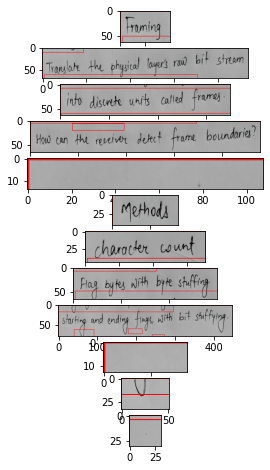

In [221]:
# plt.imshow(image[0])]
plt.figure(figsize=(15,8))
for i in range(length_of_lines):
  plt.subplot(length_of_lines,1,i+1)
  plt.imshow(image[-i-1])

In [204]:
image

[array([[[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [255,   0,   0],
         [255,   0,   0],
         [255,   0,   0]],
 
        [[255,   0,   0],
         [170, 170, 170],
         [172, 172, 172],
         ...,
         [175, 175, 175],
         [174, 174, 174],
         [177, 177, 177]],
 
        [[255,   0,   0],
         [171, 171, 171],
         [170, 170, 170],
         ...,
         [173, 173, 173],
         [174, 174, 174],
         [175, 175, 175]],
 
        ...,
 
        [[255,   0,   0],
         [173, 173, 173],
         [174, 174, 174],
         ...,
         [177, 177, 177],
         [176, 176, 176],
         [175, 175, 175]],
 
        [[255,   0,   0],
         [172, 172, 172],
         [175, 175, 175],
         ...,
         [176, 176, 176],
         [176, 176, 176],
         [173, 173, 173]],
 
        [[255,   0,   0],
         [170, 170, 170],
         [172, 172, 172],
         ...,
         [175, 175, 175],
  

In [ ]:
!pip install transformers[torch]

In [112]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


In [113]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten") 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [114]:
m = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/TrOcr")

In [79]:
from PIL import Image
from IPython.display import display
import torch 

In [109]:
# m2 = torch.load('/content/drive/MyDrive/TrOcr/pytorch_model.bin')

In [186]:
def show_image(pathStr):
  img = Image.open(pathStr).convert("RGB")
  display(pathStr)
  return img

In [187]:
def ocr_image(src_img):
  pixel_values = processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = m.generate(pixel_values)
  return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [188]:
def gen(i):
  cv2.imwrite('/content/drive/MyDrive/download/2.png',image[i])
  hw_image = show_image('/content/drive/MyDrive/download/2.png')
  return hw_image

In [ ]:
hw_image = show_image('/content/drive/MyDrive/download/2.png')
hw_image

In [ ]:
type(hw_image)

In [222]:
text = []
for i in range(length_of_lines):
  
  each_line = ocr_image(gen(-i-1))
  text.append(each_line)
  print(each_line)
 

'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


framing.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Translate the physical layer's raw bit stream


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


into discrete units called frames.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


How can the receiver detect frame boundaries?


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1961 62.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


methods.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


character count.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


flag bytes with byte stuffing.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


starting and ending flags, with bit stuffying.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


0 0


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


n.


'/content/drive/MyDrive/download/2.png'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


0.


In [223]:
text

['framing.',
 "Translate the physical layer's raw bit stream",
 'into discrete units called frames.',
 'How can the receiver detect frame boundaries?',
 '1961 62.',
 'methods.',
 'character count.',
 'flag bytes with byte stuffing.',
 'starting and ending flags, with bit stuffying.',
 '0 0',
 'n.',
 '0.']

In [224]:
!git init

Initialized empty Git repository in /content/.git/


In [ ]:
!git config --global 